# Taylor Factor Calculation for Uniaxial Loading of BCC Polycrystal

This notebook computes the Taylor factor M for:
- a BCC grain with a given orientation
- a BCC polycrystal by averaging many random crystal orientations

**Assumptions:**
- Slip systems: {110}<111> and (optionally for elevated temperatures) {112}<111>, {123}<111>
- Plastic deformation only by slip
- Uniaxial loading in x-direction (isochoric):
      eps_macro = diag(1, -0.5, -0.5)

**Taylor factor definition:**
    M = sum(|gamma_s|) / eps11

where gamma_s are the slip shear rates solving:
    eps_macro = Σ gamma_s * P_s  (P_s = sym(m ⊗ n))

**How to use:**
1. Run the cell below.
2. Modify `include_112=False, include_123=False` in `1. BCC slip systems generator` if you do not wish to constrain the slip systems to room temperature.
3. Modify `N_grains` to average over an increasing number of randomly oriented grains. This yield the average polycrystalline Taylor factor, as well as a distribution of the individual factor of the grains.

**Author:**
- B. Merle @ Uni Kassel, 2025
- GNU General Public License v3.0

In [34]:
import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt

In [35]:
# ============================================================
# 1. BCC slip systems generator
# ============================================================
#
# We generate:
# - plane normals for {110}, {112}, {123} (up to sign, i.e. n and -n are one plane)
# - <111> directions (again up to sign)
# - for each plane, keep directions with m·n = 0 (in-plane)
# - for each ±m pair, keep one representative
#
# This yields a symmetric set of BCC slip systems.
# You can choose which families to include via 'include_110', 'include_112', 'include_123'.
# At room temperature, usually only {110}<111> is active.

def _canonical_sign(v):
    """
    Return a 'canonical' version of integer vector v
    to collapse ±v into one representative.

    Rule: find first non-zero component; make it positive.
    This way, v and -v map to the same tuple.
    """
    v = np.array(v, dtype=int)
    for i in range(3):
        if v[i] > 0:
            return tuple(v)
        if v[i] < 0:
            return tuple(-v)
    # all zeros (should not happen here)
    return tuple(v)


def _unique_planes_for_family(family):
    """
    Generate unique plane normals (integer triplets) for a given BCC family:
      family ∈ {"110", "112", "123"}

    Returns
    -------
    list of 3D integer tuples in canonical sign form, representing (hkl).
    """
    planes = set()

    # We brute-force small integer triplets and filter them
    if family == "110":
        # |n|^2 = 1^2 + 1^2 + 0^2 = 2, abs components = {1,1,0}
        candidates = []
        for a in [-1, 0, 1]:
            for b in [-1, 0, 1]:
                for c in [-1, 0, 1]:
                    if (a, b, c) == (0, 0, 0):
                        continue
                    if a*a + b*b + c*c == 2 and sorted(map(abs, (a, b, c))) == [0, 1, 1]:
                        candidates.append((a, b, c))

    elif family == "112":
        # |n|^2 = 1^2 + 1^2 + 2^2 = 6, abs components = {1,1,2}
        candidates = []
        for a in [-2, -1, 0, 1, 2]:
            for b in [-2, -1, 0, 1, 2]:
                for c in [-2, -1, 0, 1, 2]:
                    if (a, b, c) == (0, 0, 0):
                        continue
                    if a*a + b*b + c*c == 6 and sorted(map(abs, (a, b, c))) == [1, 1, 2]:
                        candidates.append((a, b, c))

    elif family == "123":
        # |n|^2 = 1^2 + 2^2 + 3^2 = 14, abs components = {1,2,3}
        candidates = []
        for a in [-3, -2, -1, 0, 1, 2, 3]:
            for b in [-3, -2, -1, 0, 1, 2, 3]:
                for c in [-3, -2, -1, 0, 1, 2, 3]:
                    if (a, b, c) == (0, 0, 0):
                        continue
                    if a*a + b*b + c*c == 14 and sorted(map(abs, (a, b, c))) == [1, 2, 3]:
                        candidates.append((a, b, c))
    else:
        raise ValueError("Unknown family: " + str(family))

    for v in candidates:
        planes.add(_canonical_sign(v))

    return sorted(planes)


def get_bcc_slip_systems(include_110, include_112, include_123):
    """
    Generate BCC slip systems (m, n) with:
      - planes from {110}, {112}, {123} (depending on flags)
      - m in <111>, lying in the plane (m·n = 0)

    Returns
    -------
    systems_normed : list of (m_norm, n_norm)
        Slip directions and plane normals as unit vectors (float).
        Used for Taylor factor calculations.
    systems : list of (m_int, n_int)
        Integer [uvw] and (hkl) vectors (not normalized), for printing.
    """
    families = []
    if include_110:
        families.append("110")
    if include_112:
        families.append("112")
    if include_123:
        families.append("123")

    # All <111> directions (integer) and collapse ± pairs
    dirs_111 = set()
    for a in [-1, 1]:
        for b in [-1, 1]:
            for c in [-1, 1]:
                dirs_111.add(_canonical_sign((a, b, c)))
    dirs_111 = [np.array(v, dtype=float) for v in sorted(dirs_111)]

    systems = []         # integer version (m_int, n_int)
    systems_normed = []  # normalized version (m_norm, n_norm)

    for fam in families:
        plane_normals = _unique_planes_for_family(fam)

        for n_int in plane_normals:
            n = np.array(n_int, dtype=float)
            n_norm = n / np.linalg.norm(n)

            # Find <111> directions in the plane: m·n = 0
            inplane_dirs = []
            for m in dirs_111:
                if abs(np.dot(m, n)) < 1e-6:
                    inplane_dirs.append(m)

            # Collapse ±m: choose canonical representative for each
            chosen = []
            seen = set()
            for m in inplane_dirs:
                canon = _canonical_sign(m.astype(int))
                if canon not in seen:
                    seen.add(canon)
                    chosen.append(np.array(canon, dtype=float))

            for m in chosen:
                m_norm = m / np.linalg.norm(m)
                systems_normed.append((m_norm, n_norm))
                systems.append((m, n))

    return systems_normed, systems


# User-defined: which families of planes should be considered
# NB: room temperature → usually only {110}<111> slip systems

slip_systems_crystal, slip_systems_miller = get_bcc_slip_systems(include_110=True, include_112=False, include_123=False) # <-- User-defined
# Outputs [0]: normalized plane and direction vectors of slip systems (for calculations) [1]: Miller indices (for visualization)

print(f"Number of BCC slip systems: {len(slip_systems_miller)}")

print("\nPlane(hkl)   Direction[uvw] \n---------------------------")
for m_int, n_int in slip_systems_miller:
    # n_int is (hkl), m_int is [uvw]
    print(
        f"({n_int[0]:.0f},{n_int[1]:.0f},{n_int[2]:.0f})   "
        f"[{m_int[0]:.0f},{m_int[1]:.0f},{m_int[2]:.0f}]"
    )

Number of BCC slip systems: 12

Plane(hkl)   Direction[uvw] 
---------------------------
(0,1,-1)   [1,-1,-1]
(0,1,-1)   [1,1,1]
(0,1,1)   [1,-1,1]
(0,1,1)   [1,1,-1]
(1,-1,0)   [1,1,-1]
(1,-1,0)   [1,1,1]
(1,0,-1)   [1,-1,1]
(1,0,-1)   [1,1,1]
(1,0,1)   [1,-1,-1]
(1,0,1)   [1,1,-1]
(1,1,0)   [1,-1,-1]
(1,1,0)   [1,-1,1]


In [36]:
# ============================================================
# 2. Euler angles → rotation matrix (Bunge convention)
# ============================================================

# Bunge convention:
#     g = R_z(phi1) · R_x(Phi) · R_z(phi2)
#
# The rotation matrix g transforms vectors from the crystal reference frame
# to the sample (loading) reference frame.

def rotation_matrix_from_euler_bunge(phi1, Phi, phi2, degrees=True):
    """
    Return rotation matrix g from Bunge Euler angles (phi1, Phi, phi2).

    Parameters
    ----------
    phi1, Phi, phi2 : floats
        Bunge Euler angles defining crystal orientation.
    degrees : bool
        If True, angles are given in degrees and converted to radians.

    Returns
    -------
    g : (3x3) numpy array
        Rotation matrix from crystal to sample frame.
    """
    if degrees:
        phi1 = np.deg2rad(phi1)
        Phi  = np.deg2rad(Phi)
        phi2 = np.deg2rad(phi2)

    def R_z(a):
        c, s = np.cos(a), np.sin(a)
        return np.array([[c, -s, 0.0],
                         [s,  c, 0.0],
                         [0.0, 0.0, 1.0]])

    def R_x(a):
        c, s = np.cos(a), np.sin(a)
        return np.array([[1.0, 0.0, 0.0],
                         [0.0,  c, -s],
                         [0.0,  s,  c]])

    return R_z(phi1) @ R_x(Phi) @ R_z(phi2)

In [37]:
# ==============================================
# 3. Build linear system: eps_macro = A * gamma
# ==============================================

# Each slip system contributes a shear strain tensor:
#     P_s = 0.5 (m ⊗ n + n ⊗ m)
#
# The macroscopic plastic strain is:
#     eps_macro = Σ gamma_s * P_s
#
# For the linear programming solver, we represent symmetric tensors as 6-vectors:
#     [e11, e22, e33, e12, e13, e23]
#
# Then we can write:
#     eps_vec = A * gamma
# where A is a 6 × Ns matrix (Ns = number of slip systems).

def sym_tensor_to_vec(E):
    """
    Convert a symmetric 3×3 strain tensor E into a 6-component vector:
    [E11, E22, E33, E12, E13, E23].
    """
    return np.array([
        E[0, 0],
        E[1, 1],
        E[2, 2],
        E[0, 1],
        E[0, 2],
        E[1, 2],
    ])


def build_A_matrix(slip_systems_sample):
    """
    Build the matrix A (6 × Ns) that relates slip rates gamma_s to the macroscopic strain.

    Parameters
    ----------
    slip_systems_sample : list of (m, n)
        Slip directions and plane normals in the sample frame.

    Returns
    -------
    A : (6 × Ns) numpy array
        Column s corresponds to the contribution of slip system s to the strain vector.
    """
    Ns = len(slip_systems_sample)
    A = np.zeros((6, Ns))

    for s, (m, n) in enumerate(slip_systems_sample):
        # P_s = 0.5 (m ⊗ n + n ⊗ m) is the symmetric shear strain from slip system s
        P = 0.5 * (np.outer(m, n) + np.outer(n, m))
        # Convert P to 6-vector and store in column s
        A[:, s] = sym_tensor_to_vec(P)

    return A

In [38]:
# ============================================================================
# 4. Taylor minimization (L1) using linear programming to solve for slip shear
# ============================================================================

# We want to minimize the total shear (sum of absolute slip rates):
#     minimize Σ |γ_s|
# subject to:
#     A * γ = eps_macro
#
# This corresponds to Taylor's assumption of homogeneous strain with
# minimum total shear in the grains.
#
# We solve this with linear programming by splitting
#     γ_s = γ_s⁺ − γ_s⁻,  with γ_s⁺ ≥ 0, γ_s⁻ ≥ 0,
# and minimizing Σ (γ_s⁺ + γ_s⁻).

def solve_taylor_minimization(A, eps_vec):
    """
    Solve for the slip rates gamma_s by minimizing Σ|gamma_s| using linear programming.

    Parameters
    ----------
    A : (6 × Ns) numpy array
        Strain contribution matrix.
    eps_vec : (6,) numpy array
        Macroscopic strain vector (flattened).

    Returns
    -------
    gamma : (Ns,) numpy array
        Slip rates for each slip system that minimize total shear.
    """
    Ns = A.shape[1]

    # LP variable vector x = [gamma_plus (Ns), gamma_minus (Ns)]
    # Objective: minimize sum of gamma_plus and gamma_minus
    c = np.ones(2 * Ns)

    # Equality constraints: A * (gamma_plus - gamma_minus) = eps_vec
    A_eq = np.hstack((A, -A))
    b_eq = eps_vec

    # Bounds: gamma_plus >= 0, gamma_minus >= 0 (no upper bound)
    bounds = [(0, None)] * (2 * Ns)

    # Solve linear program using SciPy's 'highs' solver
    res = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method="highs")

    if not res.success:
        raise RuntimeError("LP did not converge: " + res.message)

    x = res.x
    # Extract gamma_plus and gamma_minus from the solution
    gamma_plus, gamma_minus = x[:Ns], x[Ns:]

    # Physical slip rate gamma_s = gamma_plus - gamma_minus
    return gamma_plus - gamma_minus

In [39]:
# ============================================================
# 5. Compute Taylor factor for a single orientation
# ============================================================

# Steps:
# 1. Build rotation matrix g from Euler angles.
# 2. Rotate slip systems from crystal frame to sample frame.
# 3. Build A matrix from slip systems in sample frame.
# 4. Solve the linear program to get slip rates gamma_s.
# 5. Compute Taylor factor M = Σ|γ_s| / ε₁₁.

def taylor_factor_for_orientation(phi1, Phi, phi2, degrees=True):
    """
    Compute Taylor factor M for a single FCC crystal orientation.

    Parameters
    ----------
    phi1, Phi, phi2 : floats
        Bunge Euler angles of the crystal.
    degrees : bool
        If True, angles are given in degrees.

    Returns
    -------
    M : float
        Taylor factor for this orientation under uniaxial tension in x.
    gamma : (Ns,) numpy array
        Slip rates on each slip system.
    """
    # Rotation matrix from crystal to sample frame
    g = rotation_matrix_from_euler_bunge(phi1, Phi, phi2, degrees)

    # Rotate each slip system (m, n) into the sample frame: m' = g m, n' = g n
    slip_systems_sample = [(g @ m, g @ n) for (m, n) in slip_systems_crystal]

    # Build A matrix for these slip systems
    A = build_A_matrix(slip_systems_sample)

    # Isochoric uniaxial tension along x:
    # eps11 = +1, eps22 = eps33 = -0.5 (to keep volume constant: trace = 0)
    eps_macro = np.array([[ 1.0,  0.0,  0.0],
                          [ 0.0, -0.5,  0.0],
                          [ 0.0,  0.0, -0.5]])
    eps_vec = sym_tensor_to_vec(eps_macro)

    # Solve for slip rates gamma_s
    gamma = solve_taylor_minimization(A, eps_vec)

    # Taylor factor: total shear divided by axial strain ε11
    M = np.sum(np.abs(gamma)) / eps_macro[0, 0]  # ε11 = 1

    return M, gamma

In [44]:
# ============================================================
# Example: Single grain with [110] // loading direction
# ============================================================
#
# For this orientation, the sample x-axis aligns with the crystal [110] direction.
# This corresponds to Euler angles (phi1, Phi, phi2) = (45, 0, 0).

M_110, gamma_110 = taylor_factor_for_orientation(45, 0, 0) # <-- user defined, can be changed to other loading direction
print(f"Taylor factor for [110] grain: M = {M_110:.3f}")

# --------------------------------------------
# Identify and print activated slip systems
# --------------------------------------------

print("\nActivated slip systems for [110] // tension direction:")
print("--------------------------------------------------------")
print("plane       direction   gamma_s")

# slip_systems: list of (m_int, n_int) integer vectors
# gamma_110: slip rates for each system in the example

for i, gamma_s in enumerate(gamma_110):
    if abs(gamma_s) > 1e-12:
        m_int, n_int = slip_systems[i]   # integer slip direction and plane normal
        print(f"({n_int[0]:.0f} {n_int[1]:.0f} {n_int[2]:.0f})    "
              f"[{m_int[0]:.0f} {m_int[1]:.0f} {m_int[2]:.0f}]     "
              f"{gamma_s:.4f}")

Taylor factor for [110] grain: M = 3.674

Activated slip systems for [110] // tension direction:
--------------------------------------------------------
plane       direction   gamma_s
(0 1 -1)    [1 -1 -1]     -1.5309
(0 1 1)    [1 -1 1]     -0.3062
(0 1 1)    [1 1 -1]     -1.2247
(1 0 -1)    [1 -1 1]     0.3062
(1 0 1)    [1 -1 -1]     0.3062


In [42]:
# ============================================================
# 6. Random polycrystal simulation
# ============================================================

# To approximate a random polycrystal, we:
# - generate many random crystal orientations (uniform on SO(3))
# - compute the Taylor factor M for each grain
# - take the average M over all grains

def random_euler_angles_uniform_SO3(num, degrees=True):
    """
    Generate 'num' random Bunge Euler angles (phi1, Phi, phi2)
    that are uniformly distributed over all possible orientations (SO(3)).

    Method:
      - phi1 ~ U(0, 2π)
      - phi2 ~ U(0, 2π)
      - cos(Phi) ~ U(-1, 1)  → ensures p(Phi) ∝ sin(Phi), i.e. uniform on the sphere.
    """
    rng = np.random.default_rng()

    # Uniform in [0, 2π) for rotations about z
    phi1 = rng.uniform(0.0, 2.0 * np.pi, num)
    phi2 = rng.uniform(0.0, 2.0 * np.pi, num)

    # cos(Phi) uniform in [-1, 1]
    u = rng.uniform(-1.0, 1.0, num)
    Phi = np.arccos(u)   # Phi in [0, π]

    if degrees:
        phi1 = np.rad2deg(phi1)
        Phi  = np.rad2deg(Phi)
        phi2 = np.rad2deg(phi2)

    return phi1, Phi, phi2


def taylor_factor_polycrystal(num_grains=1000):
    """
    Compute the mean Taylor factor for a random FCC polycrystal.

    Parameters
    ----------
    num_grains : int
        Number of grains (orientations) to simulate.

    Returns
    -------
    M_mean : float
        Average Taylor factor over all grains.
    M_list : (num_grains,) numpy array
        Taylor factor for each grain.
    """
    # Generate random orientations
    phi1_list, Phi_list, phi2_list = random_euler_angles_uniform_SO3(num_grains, degrees=True)

    M_list = []
    # Loop over grains and compute M for each orientation
    for phi1, Phi, phi2 in zip(phi1_list, Phi_list, phi2_list):
        M, _ = taylor_factor_for_orientation(phi1, Phi, phi2, degrees=True)
        M_list.append(M)

    M_list = np.array(M_list)
    return np.mean(M_list), M_list

Mean Taylor factor for random FCC polycrystal: 3.060
Range: min=2.290, max=3.674



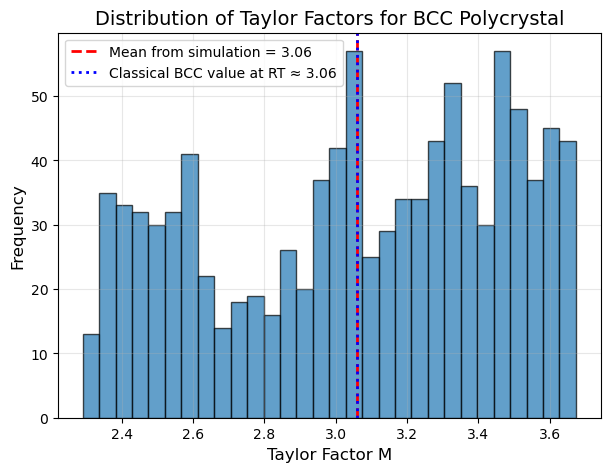

In [43]:
# ============================================================
# Run: Polycrystal with N grains (e.g. 1000)
# ============================================================

# This gives a numerical estimate of the classical Taylor factor
# for a BCC polycrystal in uniaxial tension.

N_grains=1000 # <--- User-defined number of grains

M_mean, M_list = taylor_factor_polycrystal(N_grains) 
print(f"Mean Taylor factor for random FCC polycrystal: {M_mean:.3f}")
print(f"Range: min={M_list.min():.3f}, max={M_list.max():.3f}\n")

# -------------------------------------------------------------
# Plot distribution of Taylor factors for the random polycrystal
# -------------------------------------------------------------

plt.figure(figsize=(7,5))

# Histogram of the Taylor factors
plt.hist(M_list, bins=30, edgecolor='black', alpha=0.7)

# Plot the numerical mean from simulation
plt.axvline(M_mean, color='red', linestyle='--', linewidth=2,
            label=f"Mean from simulation = {M_mean:.2f}")

# Classical Taylor factor for BCC polycrystals (~3.06)
plt.axvline(3.06, color='blue', linestyle=':', linewidth=2,
            label="Classical BCC value at RT ≈ 3.06")

plt.xlabel("Taylor Factor M", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Distribution of Taylor Factors for BCC Polycrystal", fontsize=14)
plt.legend()
plt.grid(alpha=0.3)

plt.show()